# Bert

In [32]:
import torch
import pandas as pd
import numpy as np

In [26]:
def drop(data_frame: pd.DataFrame, keys):
    for key in keys:
        del data_frame[key]

In [30]:
raw = pd.read_csv('data/raw/train.csv')

In [31]:
raw = raw.sample(frac=1, random_state=32)
input = raw.reset_index(drop=True)
input

,ID,code,Label
0,14708,static void gen_ori(DisasContext *ctx)\n\n{\n\...,1
1,14706,static int get_physical_address_data(CPUState ...,1
2,15628,static void scsi_unmap_complete_noio(UnmapCBDa...,0
3,16510,"static int drive_add(const char *file, const c...",1
4,18155,static int vsink_query_formats(AVFilterContext...,0
...,...,...,...
19995,6745,static void v9fs_xattrcreate(void *opaque)\n\n...,1
19996,19527,"static int estimate_qp(MpegEncContext *s, int ...",1
19997,9526,static int xhci_fire_ctl_transfer(XHCIState *x...,1
19998,9771,void resume_all_vcpus(void)\n\n{\n\n}\n,1


In [29]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from transformers import RobertaTokenizer, RobertaModel
torch.manual_seed(2020)

class CodeBertClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(CodeBertClassifier, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.bert = RobertaModel.from_pretrained('microsoft/codebert-base').to(self.device)
        self.tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes).to(self.device)

    def forward(self, input_ids, attention_mask):
        input_ids = input_ids.to(self.device)
        attention_mask = attention_mask.to(self.device)
        outputs = self.bert(input_ids, attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output.to(self.device))
        logits = self.fc(x)
        return logits

    def save(self, path):
        print(path)
        torch.save(self.state_dict(), path)
        print(f"Model saved to {path}")

    def load(self, path):
        self.load_state_dict(torch.load(path))  

In [ ]:
total = 20000
data = input["code"].tolist()[:total]
train_size = 16000
validate_size = 2000
test_size = 2000

train_indices = range(train_size)
validate_indices = range(train_size, train_size + validate_size)
test_indices = range(train_size + validate_size, train_size + validate_size + test_size)

y_train = torch.tensor(input.iloc[train_indices, 2].values).to(torch.int64)
y_validate = torch.tensor(input.iloc[validate_indices, 2].values).to(torch.int64)
y_test = torch.tensor(input.iloc[test_indices, 2].values).to(torch.int64)


In [34]:
nb_class = 2
def encode_input(text, tokenizer):
    max_length = 256
    input = tokenizer(text, max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')

    return input['input_ids'], input['attention_mask']

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
input_ids_, attention_mask_ = encode_input(data, tokenizer)

In [39]:
import torch
from torch.utils import data as Data

def to_device(data_dict, device):
    for key in data_dict:
        data_dict[key] = data_dict[key].to(device)
    return data_dict

data_splits = {
    'train': (0, train_size),
    'val': (train_size, train_size + validate_size),
    'test': (-test_size, None)
}

input_ids = {}
attention_mask = {}
label = {}

for split, (start, end) in data_splits.items():
    input_ids[split] = input_ids_[start:end]
    attention_mask[split] = attention_mask_[start:end]
    label[split] = {'train': y_train, 'val': y_validate, 'test': y_test}[split]
    
input_ids = to_device(input_ids, device)
attention_mask = to_device(attention_mask, device)
label = to_device(label, device)

batch_size = 32
datasets = {}
loader = {}

for split in ['train', 'val', 'test']:
    datasets[split] = Data.TensorDataset(input_ids[split], attention_mask[split], label[split])
    loader[split] = Data.DataLoader(datasets[split], batch_size=batch_size, shuffle=True)


In [43]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (x1, x2, y) in enumerate(train_loader):
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        y_pred = model(x1, x2)
        model.zero_grad()
        
        loss = F.cross_entropy(y_pred, y.squeeze())
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 100 == 0:
            print(f'Train Epoch: {epoch} [{(batch_idx + 1) * len(x1)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.2f}%)]\tLoss: {loss.item():.6f}')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0.0
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for x1, x2, y in test_loader:
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            y_ = model(x1, x2)
            
            test_loss += F.cross_entropy(y_, y.squeeze()).item()
            
            pred = y_.max(dim=-1)[1]
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    test_loss /= len(test_loader)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy*100:.2f}%, Precision: {precision*100:.2f}%, '
          f'Recall: {recall*100:.2f}%, F1: {f1*100:.2f}%')
    
    return accuracy, precision, recall, f1


In [37]:
model = CodeBertClassifier().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)

Train Epoch: 1 [3200/16000 (19.80%)]	Loss: 0.596430
Train Epoch: 1 [6400/16000 (39.80%)]	Loss: 0.643996
Train Epoch: 1 [9600/16000 (59.80%)]	Loss: 0.552560
Train Epoch: 1 [12800/16000 (79.80%)]	Loss: 0.619023
Train Epoch: 1 [16000/16000 (99.80%)]	Loss: 0.536921


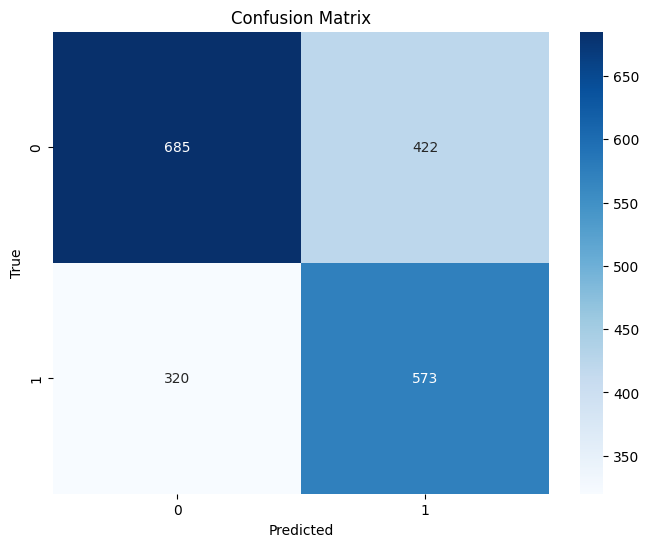

Test set: Average loss: 0.6050, Accuracy: 62.90%, Precision: 57.59%, Recall: 64.17%, F1: 60.70%
Accuracy is: 0.6290, best accuracy is 0.6290n
Train Epoch: 2 [3200/16000 (19.80%)]	Loss: 0.672880
Train Epoch: 2 [6400/16000 (39.80%)]	Loss: 0.299208
Train Epoch: 2 [9600/16000 (59.80%)]	Loss: 0.478536
Train Epoch: 2 [12800/16000 (79.80%)]	Loss: 0.844932
Train Epoch: 2 [16000/16000 (99.80%)]	Loss: 0.658955


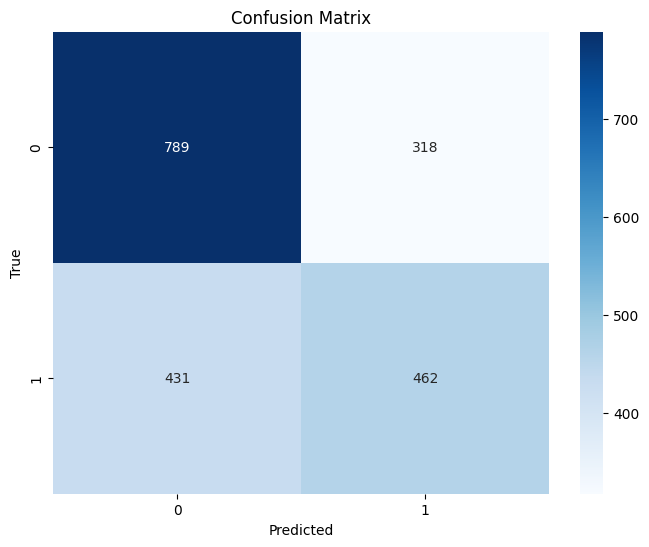

Test set: Average loss: 0.6132, Accuracy: 62.55%, Precision: 59.23%, Recall: 51.74%, F1: 55.23%
Accuracy is: 0.6255, best accuracy is 0.6290n
Train Epoch: 3 [3200/16000 (19.80%)]	Loss: 0.422958
Train Epoch: 3 [6400/16000 (39.80%)]	Loss: 0.546822
Train Epoch: 3 [9600/16000 (59.80%)]	Loss: 0.449572
Train Epoch: 3 [12800/16000 (79.80%)]	Loss: 0.595746
Train Epoch: 3 [16000/16000 (99.80%)]	Loss: 0.456690


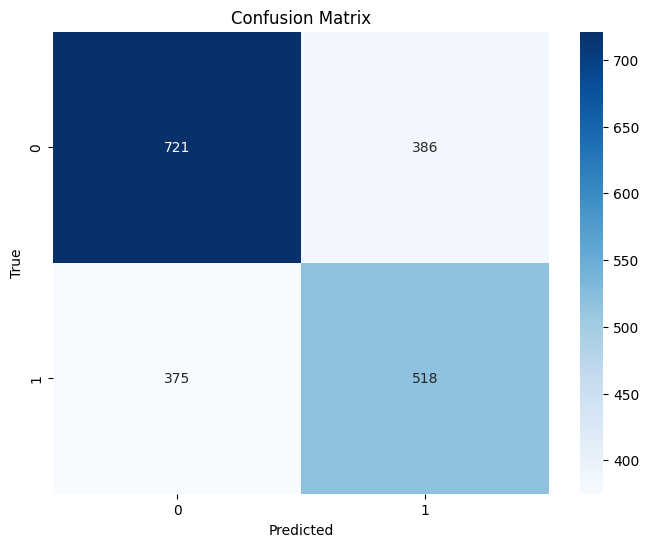

Test set: Average loss: 0.6821, Accuracy: 61.95%, Precision: 57.30%, Recall: 58.01%, F1: 57.65%
Accuracy is: 0.6195, best accuracy is 0.6290n
Train Epoch: 4 [3200/16000 (19.80%)]	Loss: 0.297489
Train Epoch: 4 [6400/16000 (39.80%)]	Loss: 0.438496
Train Epoch: 4 [9600/16000 (59.80%)]	Loss: 0.428237
Train Epoch: 4 [12800/16000 (79.80%)]	Loss: 0.375953
Train Epoch: 4 [16000/16000 (99.80%)]	Loss: 0.424937


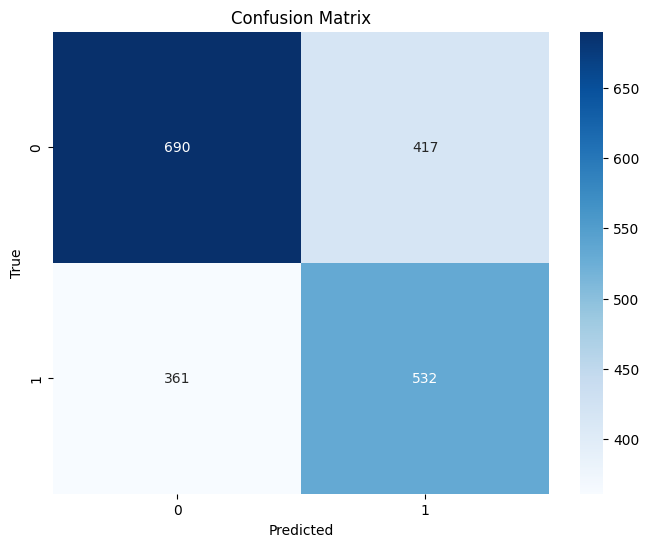

Test set: Average loss: 0.7793, Accuracy: 61.10%, Precision: 56.06%, Recall: 59.57%, F1: 57.76%
Accuracy is: 0.6110, best accuracy is 0.6290n
Train Epoch: 5 [3200/16000 (19.80%)]	Loss: 0.357804
Train Epoch: 5 [6400/16000 (39.80%)]	Loss: 0.289316
Train Epoch: 5 [9600/16000 (59.80%)]	Loss: 0.444818
Train Epoch: 5 [12800/16000 (79.80%)]	Loss: 0.480676
Train Epoch: 5 [16000/16000 (99.80%)]	Loss: 0.279129


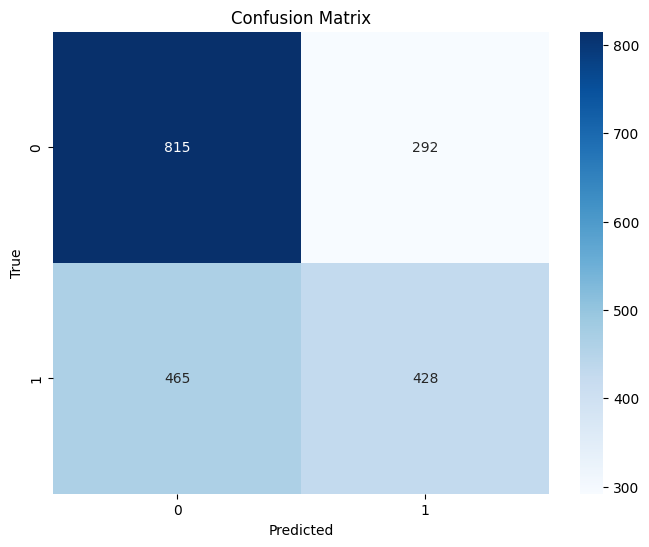

Test set: Average loss: 0.9746, Accuracy: 62.15%, Precision: 59.44%, Recall: 47.93%, F1: 53.07%
Accuracy is: 0.6215, best accuracy is 0.6290n


In [44]:
best_acc = 0.0
num_epochs = 5
PATH = 'model.pth'
for epoch in range(1, num_epochs + 1):
    train(model, device, loader["train"], optimizer, epoch)
    acc, precision, recall, f1 = test(model, device, loader["val"])
    if best_acc < acc:
        best_acc = acc
        torch.save(model.state_dict(), PATH)
    print("Accuracy is: {:.4f}, best accuracy is {:.4f}n".format(acc, best_acc))

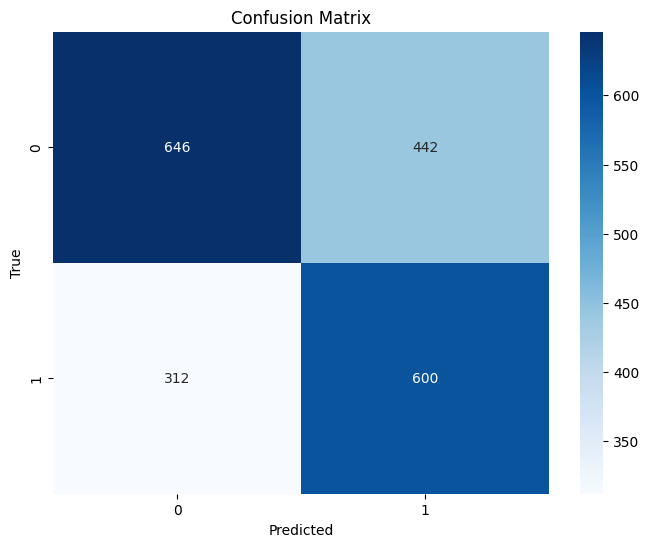

Test set: Average loss: 0.6062, Accuracy: 62.30%, Precision: 57.58%, Recall: 65.79%, F1: 61.41%


In [47]:
model_test = CodeBertClassifier().to("cuda")
model_test.load_state_dict(torch.load("model.pth", weights_only=True))
accuracy, precision, recall, f1 = test(model_test, device, loader['test'])

In [48]:
model.save('model.pth')

model.pth
Model saved to model.pth


In [ ]:
model = CodeBertClassifier().to("cuda")
model.load("model.pth", weights_only=True)
model.eval()

C:\Users\dmt07\AppData\Local\Temp\ipykernel_10308\3423294752.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


CodeBertClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [ ]:
test = pd.read_csv('data/raw/test.csv')
input_dataset = test

,func
0,static void avc_luma_vt_and_aver_dst_8x8_msa(c...
1,"static void pc_init1(MachineState *machine,\n\..."
2,"void ioinst_handle_rchp(S390CPU *cpu, uint64_t..."
3,static void mpegts_write_pmt(AVFormatContext *...
4,static int do_setcontext(struct target_ucontex...
...,...
6995,static CURLState *curl_init_state(BDRVCURLStat...
6996,int qsv_transcode_init(OutputStream *ost)\n\n{...
6997,static void i6300esb_pc_init(PCIBus *pci_bus)\...
6998,static void idr(H264Context *h){\n\n int i;...


In [ ]:
total = 7000
data = input_dataset["code"].tolist()[:total]

In [13]:
preds = []
for i in range(len(data)):
    input_ids_, attention_mask_ = encode_input(data[i], tokenizer)
    logits = model(input_ids_, attention_mask_)
    pred = logits.argmax(dim=-1).cpu().numpy()
    preds.append(pred)

In [ ]:
ids = list(range(7000))
submission_df = pd.DataFrame({
    'ID': ids,
    'pred': preds
})
submission_df.to_csv('submit.csv', index=False)